In [ ]:
pip install translate

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [ ]:
file_location = "/FileStore/tables/rad/df_eBike_UVP.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
          .option("inferSchema", infer_schema) \
          .option("header", first_row_is_header) \
          .option("sep", delimiter) \
          .load(file_location)

# # Save as a Parquet Table
# df.write.format("parquet").mode("overwrite").saveAsTable("df_eBike_UVP_csv")

In [ ]:
ebike = df.toPandas()

In [ ]:
ebike.display()

In [ ]:
ebike.info()

In [ ]:
%run "/Users/datascienceexpertmentors@gmail.com/ML/Supervised Learning/functions_lib.py"

In [ ]:
from translate import Translator

translator = Translator(from_lang='de', to_lang='tr')

# Translate column names
translated_columns = []

for column in ebike.columns:
    translation = translator.translate(column)
    translated_text = translation if translation is not None else column
    translated_columns.append(translated_text)

In [ ]:
ebike_tr = ebike.rename(columns=dict(zip(ebike.columns, translated_columns)))
ebike_tr.head()

In [ ]:
dict(zip(df.columns, translated_columns))

In [ ]:
translated_columns

In [ ]:
first_looking(ebike)
duplicate_values(ebike)

In [ ]:
ebike.info()

In [ ]:
ebike.sample(10).T

In [ ]:
import pandas as pd

# Create an empty list to store the zipped column names and value counts
zipped_data = []

# Iterate over each column in the DataFrame
for column in ebike.columns:
    column_name = column
    value_counts = ebike[column].nunique()
    zipped_data.append((column_name, value_counts))

# Create a DataFrame from the zipped data
df_counts = pd.DataFrame(zipped_data, columns=['Column', 'Value Counts'])

# Sort the DataFrame by 'Value Counts' in descending order
df_counts_sorted = df_counts.sort_values(by='Value Counts', ascending=False)

df_counts_sorted

#### The Examination of Features & Target

##### Target

In [ ]:
target = "uvp_€"
cprint(f"Have a first look to {target}:","blue","on_grey", attrs=["bold"])
summary(ebike, target)

In [ ]:
ebike[[target]].describe()

##### Features

In [ ]:
for feature_col in ebike.columns:
    cprint(f"Have a first look to {feature_col}:","blue","on_grey", attrs=["bold"])
    summary(ebike, feature_col)

In [ ]:
ebike[[target]].max()

In [ ]:
ebike[ebike[target]==15999]

In [ ]:
# Exclude non-numeric columns
numeric_columns = ebike.drop(columns=target).select_dtypes(include=[int, float]).columns

# Calculate correlation
correlations = {}
for column in numeric_columns:
    correlation = ebike[target].corr(ebike[column])
    correlations[column] = correlation

# Sort correlations in descending order
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)

# Print sorted correlations
for column, correlation in sorted_correlations:
    print(f"Correlation between '{target}' and '{column}': {correlation}")


In [ ]:
plt.figure(figsize=(12, 8))

# Plot heatmap
sns.heatmap(ebike.corr(), annot=True)

In [ ]:
sns.pairplot(ebike[[target, "gabel_federweg_mm", "lenkerbreite_mm"]], palette='r');

In [ ]:
multicolinearity_control(ebike, collimit=0.50)

In [ ]:
ebike.corr()

### Assignment-1
- handling and dealing missing values
- handling and dealing outliers
- translate
- to_csv
- viz(visualization)

In [ ]:
ebike.head()

In [ ]:
ebike.drop(columns=["dämpfer", "kassette"], inplace=True)

In [ ]:
ebike.info()

In [ ]:
sorted_correlations

In [ ]:
top_correlation = sorted_correlations[:4]
top_correlation

In [ ]:
top_columns = [column for column, _ in top_correlation]
top_columns 

In [ ]:
X = ebike[[top_columns[0]]] # >>> input=feature
y = ebike[[target]]

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     random_state=42, 
                                                     shuffle=True)

In [ ]:
shape_control(ebike, X_train, y_train, X_test, y_test)

In [ ]:
X_train.shape

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False) # hyperparameter optimization
model.fit(X_train, y_train)
y_pred = model.predict(X_test)  # y_hat 
y_pred

In [ ]:
model.coef_

In [ ]:
model.intercept_

In [ ]:
# y_pred = m(==model.coef_).X_test['gabel_federweg_mm'] + n(==model.intercept_) y = mx + n

In [ ]:
X_test['gabel_federweg_mm'].loc[4447]

In [ ]:
y_test.loc[4447]

In [ ]:
y_pred_4447 = model.coef_*X_test['gabel_federweg_mm'].loc[4447] + model.intercept_
y_pred_4447
# [4289.30057593]

In [ ]:
y_test.values.ravel()

In [ ]:
y_test.values.flatten()

In [ ]:
y_dict = {"Actual": y_test.values.ravel(), "Prediction": y_pred.ravel()}
ebike_pred = pd.DataFrame(y_dict)
ebike_pred

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def eval_metric(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"r2 score: {r2.round(2)}")
    return r2, mae, mse, rmse

In [ ]:
eval_metric(y_test, y_pred);

In [ ]:
r2, mae, mse, rmse = eval_metric(y_test, y_pred)
r2, mae, mse, rmse

In [ ]:
y_test, y_pred

In [ ]:
residual = abs(y_test - y_pred)
residual

In [ ]:
y_dict = {"Actual": y_test.values.ravel(), "Prediction": y_pred.ravel(), "Error" : abs(y_test - y_pred).values.ravel()}
ebike_pred = pd.DataFrame(y_dict)
ebike_pred

In [ ]:
mae = sum(abs(y_test - y_pred).values)/len(y_test) # 719.5274842407156 

In [ ]:
mse = sum((y_test - y_pred).values**2)/len(y_test) #  1093215.2933150046
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
r2_scr = 1 - (sum((y_test - y_pred).values**2)/sum((y_test.values)**2))
r2_scr

In [ ]:
residual

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
stats.probplot(residual.values.ravel(), dist="norm", plot=plt);

Multiple Linear Regression

In [ ]:
X = ebike[top_columns]
y = ebike[[target]]
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     random_state=42, 
                                                     shuffle=True)
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False) # hyperparameter optimization
model.fit(X_train, y_train)
y_pred = model.predict(X_test)  # y_hat 
y_pred

In [ ]:
eval_metric(y_test, y_pred)

In [ ]:
model.coef_

In [ ]:
model.intercept_

## Assignment-2
- try lazypredict
- try pycaret 
  -  simple - 1 feature
  - multiple - 4 feature
  - https://machinelearningmastery.com/pycaret-for-machine-learning/

## ML Model Development

In [ ]:
!pip install lazypredict

In [ ]:
%run "/Users/datascienceexpertmentors@gmail.com/ML/Supervised Learning/functions_lib.py"

In [ ]:
pip install missingno

### Linear Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

file_location = "/FileStore/tables/rad/df_eBike_UVP.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
          .option("inferSchema", infer_schema) \
          .option("header", first_row_is_header) \
          .option("sep", delimiter) \
          .load(file_location).toPandas()


first_looking(df)
duplicate_values(df)

df.drop(columns=["dämpfer", "kassette"], inplace=True)

target = "uvp_€"

X = df[['gabel_federweg_mm', 'lenkerbreite_mm', 'akkukapazität_wh', 'unterstützung_%']].values
y = df[target]

X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     random_state=42, 
                                                     shuffle=True)

shape_control(df, X_train, y_train, X_test, y_test)

from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False) # hyperparameter optimization
model.fit(X_train, y_train)

y_pred = model.predict(X_test)  # y_hat 
y_pred

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def eval_metric(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"r2 score: {r2.round(2)}")
    return r2, mae, mse, rmse


r2, mae, mse, rmse = eval_metric(y_test, y_pred)
print("****************************************************************************************************")
print(f"Inputs: {df[['gabel_federweg_mm', 'lenkerbreite_mm', 'akkukapazität_wh', 'unterstützung_%']].columns.tolist()}")
print(f"Target: {target}")
print("****************************************************************************************************")
print(f"{model} >> r2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print("****************************************************************************************************")

### Lazy Predict

In [ ]:
from lazypredict.Supervised import LazyClassifier, LazyRegressor
lazy_regressor = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)
models, predictions = lazy_regressor.fit(X_train,
                                         X_test,
                                         y_train, 
                                         y_test)

In [ ]:
models

### PyCaret

In [ ]:
!pip install --upgrade pip
!pip uninstall pycaret scikit-learn sktime mleap -y
!pip install scikit-learn==0.24.0
!pip install pycaret

In [ ]:
from pycaret.regression import *
pycaret_redressor = setup(data=df[['gabel_federweg_mm', 'uvp_€']],
                          target=target)
compare_models()
# 'lenkerbreite_mm', 'akkukapazität_wh', 'unterstützung_%',

## Assignment-3
1- feature sayisini artir : numeric_columns 
Pycaret, LazyPredict ile sonuclara bak

2- StandardScaler ile X_train ve X_test scale yaptiktan sonra modele feature olarak ver

X_train_scaled, X_test_scaled
LazyPredict
LR

ridge lasso
ohe ile categoric columns >>> numeric

## ML Model Development Pipeline

### High-Level Outline for the Life Cycle of Developing and Deploying ML Models
**Problem Definition:** 
  - Clearly defining the problem to be solved and identifying the objectives of the machine learning project.

**Data Collection and Preparation:** 
  - Gathering relevant data and performing necessary preprocessing steps such as cleaning, transforming, and feature engineering.

**Model Selection and Design:** 
  - Choosing an appropriate machine learning algorithm or model architecture based on the problem and data characteristics.

**Model Training:** 
  - Training the selected model using the prepared data and appropriate training techniques, such as cross-validation and hyperparameter tuning.

**Model Evaluation:** 
  - Assessing the performance of the trained model using evaluation metrics and techniques to measure its accuracy, precision, recall, etc.

**Model Deployment:** 
  - Integrating the trained model into a production environment or application for real-world use.

**Model Monitoring and Maintenance:** 
  - Continuously monitoring the deployed model's performance, addressing issues, and retraining or updating the model as needed.

**Model Retraining and Improvement:** 
  - Periodically revisiting the model, retraining it with new data, and implementing improvements or enhancements to enhance its accuracy or generalization.

### Stages for the Life Cycle of Developing and Deploying ML Models

**1- Data Collection and Preprocessing:**

- "Data Acquisition and Cleaning: Gathering and Preparing Data"
- "Data Preprocessing: Cleaning and Transforming"
- "Feature Engineering: Extracting Relevant Features"

**2- Exploratory Data Analysis (EDA):**

- "Exploring Data: Statistical Analysis and Visualization"
- "Understanding Patterns: EDA for Prediction"
- "Feature Selection: Identifying Key Variables for Forecasting"

**3- Model Development and Training:**

- "Model Selection: Choosing the Right Algorithm for Prediction"
- "Model Training and Evaluation: Building an ML Model for Forecasting"
- "Hyperparameter Tuning: Optimizing Model Performance for Prediction"

**4- Model Evaluation and Validation:**

- "Model Performance Metrics: Assessing Accuracy for Prediction"
- "Cross-Validation: Evaluating Model Generalization for Forecasting"
- "Validation and Testing: Assessing Model Robustness for Prediction"

**5- Deployment and Inference:**

- "Model Deployment: Integrating Prediction Model into Production"
- "Real-Time Inference: Making Predictions in a Production Environment"
- "Monitoring and Maintenance: Ensuring Model Performance in Forecasting"

### Installments

In [ ]:
pip install xgboost

In [ ]:
pip install catboost

In [ ]:
pip install cufflinks

In [ ]:
pip install plotly

In [ ]:
pip install optuna

In [ ]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# # model selection & validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, cross_val_predict, train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_validate

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Pandas need cufflinks to link with plotly and add the iplot method:
## plotly and cufflinks
import plotly 
import plotly.express as px
import cufflinks as cf #cufflink connects plotly with pandas to create graphs and charts of dataframes directly
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## regression/prediction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, plot_importance

import optuna

In [ ]:
%run "/Users/datascienceexpertmentors@gmail.com/ML/Supervised Learning/functions_lib.py"

### Loading Dataset
      #Reading Dataset 
      #Importing Dataset

In [ ]:
file_location = "/FileStore/tables/rad/df_eBike_UVP.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
          .option("inferSchema", infer_schema) \
          .option("header", first_row_is_header) \
          .option("sep", delimiter) \
          .load(file_location).toPandas()

In [ ]:
df.head()

### Exploratory Data Analysis (EDA)

In [ ]:
first_looking(df)
duplicate_values(df)

In [ ]:
df.isnull().sum().sum()

In [ ]:
missing_values(df)

In [ ]:
df[["dämpfer", "kassette"]].sample(10)

In [ ]:
df.drop("dämpfer", axis=1, inplace=True)

In [ ]:
df[["kassette"]].info()


In [ ]:
df['kassette'].mode()

In [ ]:
df["kassette"].fillna(df['kassette'].mode()[0], inplace=True)

In [ ]:
missing_values(df)

### Model Development and Training 1-Intro

#### Train-Test Split | Scale

In [ ]:
df.head()

In [ ]:
df

In [ ]:
target = "uvp_€"

X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     random_state=42, 
                                                     shuffle=True)

shape_control(df, X_train, y_train, X_test, y_test)

numerics = X.select_dtypes(include="number").astype("float64")
categorics = X.select_dtypes(include=["object", "category", "bool"])

In [ ]:
numerics.head()

In [ ]:
categorics.head(1)

In [ ]:
X_train

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

# Standart Scaling
standard_scaler = StandardScaler()
X_train_scaled_std = standard_scaler.fit_transform(X_train.select_dtypes(include="number").astype("float64"))
X_test_scaled_std = standard_scaler.transform(X_test.select_dtypes(include="number").astype("float64"))

# MinMax Scaling
scaler = MinMaxScaler()
X_train_scaled_mm = scaler.fit_transform(X_train.select_dtypes(include="number").astype("float64"))
X_test_scaled_mm = scaler.transform(X_test.select_dtypes(include="number").astype("float64"))

# # Dealing with outliers by using Robust scaling and Power Tranform
robust_scaler = RobustScaler()
X_train_scaled_rb = robust_scaler.fit_transform(X_train.select_dtypes(include="number").astype("float64"))
X_test_scaled_rb = robust_scaler.transform(X_test.select_dtypes(include="number").astype("float64"))

power_tranformer = PowerTransformer(method='yeo-johnson')
X_train_scaled_pw = power_tranformer.fit_transform(X_train_scaled_rb)
X_test_sclaed_pw = power_tranformer.transform(X_test_scaled_rb)

In [ ]:
pd.DataFrame(X_train_scaled_std).describe()

In [ ]:
pd.DataFrame(X_test_scaled_std).describe()

In [ ]:
pd.DataFrame(X_train_scaled_mm).describe()

In [ ]:
pd.DataFrame(X_train_scaled_mm)

In [ ]:
pd.DataFrame(X_train_scaled_rb).describe()

In [ ]:
pd.DataFrame(X_train_scaled_pw).describe()

#### ML Pipeline

In [ ]:
numeric_transformer = Pipeline([('Scaler', StandardScaler())])

categorical_transformer = Pipeline([('OHE', OneHotEncoder(drop="if_binary", handle_unknown="ignore"))])

transformer = ColumnTransformer([('numeric', numeric_transformer, numerics.columns),
                                 ('categoric', categorical_transformer, categorics.columns)])

pipeline_model = Pipeline([('transform', transformer), ('prediction', RandomForestRegressor())])    

pipeline_model.fit(X_train, y_train)

y_pred = pipeline_model.predict(X_test)

##### OHE

In [ ]:
transformer.transformers_[1][1]['OHE'].get_feature_names(categorics.columns).tolist()

In [ ]:
numeric_transformer = Pipeline([('Scaler', StandardScaler())])

categorical_transformer = Pipeline([('OHE', OneHotEncoder(drop="if_binary", handle_unknown="ignore"))])

transformer = ColumnTransformer([('numeric', numeric_transformer, numerics.columns),
                                 ('categoric', categorical_transformer, categorics.columns)])
# Fit the pipeline to obtain the transformed features
transformed_features_Xtrain = transformer.fit_transform(X_train)

# Get the column names of the transformed features
transformed_feature_names_Xtrain = numerics.columns.tolist() + transformer.transformers_[1][1]['OHE'].get_feature_names(categorics.columns).tolist()

# Convert the sparse matrix to a dense matrix
transformed_features_dense_Xtrain = transformed_features_Xtrain.toarray()

# Create a DataFrame with the transformed features and their names
transformed_df_Xtrain = pd.DataFrame(transformed_features_dense_Xtrain, columns=transformed_feature_names_Xtrain)

# Display the transformed DataFrame
transformed_df_Xtrain.head()

In [ ]:
transformed_df_Xtrain.shape

In [ ]:
# Fit the pipeline to obtain the transformed features
transformed_features_Xtest = transformer.fit_transform(X_test)

# Get the column names of the transformed features
transformed_feature_names_Xtest = numerics.columns.tolist() + transformer.transformers_[1][1]['OHE'].get_feature_names(categorics.columns).tolist()

# Convert the sparse matrix to a dense matrix
transformed_features_dense_Xtest = transformed_features_Xtest.toarray()

# Create a DataFrame with the transformed features and their names
transformed_df_Xtest = pd.DataFrame(transformed_features_dense_Xtest, columns=transformed_feature_names_Xtest)

# Display the transformed DataFrame
transformed_df_Xtest.head()

In [ ]:
transformed_df_Xtest.shape

In [ ]:
# from lazypredict.Supervised import LazyClassifier, LazyRegressor
# lazy_regressor = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)
# models, predictions = lazy_regressor.fit(transformed_df_Xtrain.values,
#                                          transformed_df_Xtest.values,
#                                          y_train, 
#                                          y_test)

In [ ]:
models

### Model Evaluation and Validation

In [ ]:
def eval_metric(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"r2 score: {r2.round(2)}")
    return r2, mae, mse, rmse


r2, mae, mse, rmse = eval_metric(y_test, y_pred)
print("****************************************************************************************************")
print(f"Numeric Features: {numerics.columns.tolist()}")
print("****************************************************************************************************")
print(f"Categoric Features: {categorics.columns.tolist()}")
print("****************************************************************************************************")
print(f"Target: {target}")
print("****************************************************************************************************")
print(f"{pipeline_model[-1]} >> r2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print("****************************************************************************************************")

### Assignment-4
  1- recap
  2- feature_importance() arastir uygula

### Model Development and Training 2-Feature Importance

#### Feature Importance

In [ ]:
pipeline_model

In [ ]:
pipeline_model.named_steps

In [ ]:
pipeline_model.named_steps["prediction"]

In [ ]:
feature_importances = pipeline_model.named_steps["prediction"].feature_importances_
feature_importances

In [ ]:
transformed_feature_names_Xtrain

In [ ]:
feature_importance_dict = dict(zip(transformed_feature_names_Xtrain, feature_importances))
feature_importance_dict 

In [ ]:
sorted_feature_importances = sorted(feature_importance_dict.items(), key = lambda x:x[1], reverse=True)
sorted_feature_importances

In [ ]:
feature_names, importance = zip(*sorted_feature_importances)
feature_names[0:12]

In [ ]:
feature_names[0:12]

In [ ]:
df['unterstützung_%'].value_counts()

In [ ]:
target = "uvp_€"

X = df[['gabel_federweg_mm',
        'akkukapazität_wh',
        'rahmenmaterial',
        'sattel',
        'bremse_vorne',
        'schaltwerk',
        'kategorie',
        'hersteller']]

y = df[target]

X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     random_state=42, 
                                                     shuffle=True)

shape_control(df, X_train, y_train, X_test, y_test)

numerics = X.select_dtypes(include="number").astype("float64")
categorics = X.select_dtypes(include=["object", "category", "bool"])

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

numeric_transformer = Pipeline([('Scaler', StandardScaler()), 
                                ('R_Scaler', RobustScaler()),
                                ('Pw_Scaler', PowerTransformer())])

categorical_transformer = Pipeline([('OHE', OneHotEncoder(handle_unknown="ignore"))])

transformer = ColumnTransformer([('numeric', numeric_transformer, numerics.columns),
                                 ('categoric', categorical_transformer, categorics.columns)])

pipeline_model = Pipeline([('transform', transformer), ('prediction', RandomForestRegressor())])    

pipeline_model.fit(X_train, y_train)

y_pred = pipeline_model.predict(X_test)

In [ ]:
def eval_metric(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"r2 score: {r2.round(2)}")
    return r2, mae, mse, rmse

r2, mae, mse, rmse = eval_metric(y_test, y_pred)
print("****************************************************************************************************")
print(f"Numeric Features: {numerics.columns.tolist()}")
print("****************************************************************************************************")
print(f"Categoric Features: {categorics.columns.tolist()}")
print("****************************************************************************************************")
print(f"Target: {target}")
print("****************************************************************************************************")
print(f"{pipeline_model[-1]} >> r2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print("****************************************************************************************************")

### Assignment-5
    1- recap
    2- outlier detection - boxplotlar ile gorsellestirme
    3- handling with outliers - sinir degerlerine cekme veya uzaklastima
    4- randomforest ile en iyi ozellikleri tespit etme (optimizayson: en yüksek r2scoreu veren optimum sayida feature alinmasi - %99 basariyi 2 feature ile veya 3feature ile elde etme)
    5- SHAP ile feature importance
    6- Hyperparametre Optimization (Grid Search CV - OPTUNA)

### Model Development and Training 3-First Insights

In [ ]:
transformed_df_Xtrain.head()

In [ ]:
# #  Deails are in "functions_lib.py"
# model_selection(transformed_df_Xtrain.values, y_train)

#### First Insights to Models by Overall Train & Test Scores

In [ ]:
# Models
%matplotlib inline
models = []
models.append(("LR", LinearRegression()))  
models.append(("DTR", DecisionTreeRegressor(random_state=42)))  
models.append(("RFR", RandomForestRegressor(random_state=42)))  
models.append(("KNN", KNeighborsRegressor()))
models.append(("SVR", SVR()))  
models.append(("ADA", AdaBoostRegressor(random_state=42)))
models.append(("GBR", GradientBoostingRegressor(random_state=42)))
models.append(("ExtraTrees", ExtraTreesRegressor(random_state=42)))


# Evaluate each model in turn
results = []
names = []
r2_scores = []
mae_scores = []
mse_scores = []
rmse_scores = []
n_splits = 10

for name, model in models:
    pipe = Pipeline([('transform', transformer), ('model', model)])    
    kfold = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold)
    
    results.append(cv_results)
    names.append(name)
    
    
    print(f"{name} ~ CV Train Scores: {round(cv_results.mean(), 4)}")

    pipemodel = pipe.fit(X_train, y_train)
    y_pred = pipemodel.predict(X_test)

   
    r2_scores.append(r2_score(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mse))


# result_df = pd.DataFrame(results, columns=[i for i in range(1, n_splits+1)], index=names).T
# layout = cf.Layout(height=300, width=800, title="CV Results ~ Validation Scores")
# result_df.iplot(kind="box", boxpoints="all", layout=layout)

compare = pd.DataFrame({"R2": r2_scores,
                        "MAE": mae_scores,
                        "MSE": mse_scores,
                        "RMSE": rmse_scores
                       }, index=names)

# compare.to_csv(f"{dataset}_and_used_in_models_with default parameters.csv")

print(f"Test Scores:\n", compare)

# for score in compare.columns:
#     layout = cf.Layout(height=260, width=800, title=f"{score} Scores for Test Dataset")
#     compare[score].sort_values().iplot(kind="barh", color="blue", layout=layout)
# # https://plotly.com/python/horizontal-bar-charts/
# # https://plotly.com/python/renderers/
# # https://plotly.com/python/creating-and-updating-figures/

In [ ]:
result_df 

In [ ]:
result_df.plot(kind="box")

In [ ]:
compare.sort_values(by=["R2"], ascending=False)

#### Catboost, XGBoost, LightGBM by Default Parameters

In [ ]:

# Models
models = []
models.append(("XGB", XGBRegressor(random_state=42, 
                                    verbosity = 0
                                   )))
models.append(("LGB", LGBMRegressor(random_state=42
                                    )))
models.append(("CAT", CatBoostRegressor(random_state=42,
                                         verbose=0, 
                                         cat_features=categorics.columns.to_list()
                                        )))

# Evaluate each model in turn
results = []
names = []
r2_scores = []
mae_scores = []
mse_scores = []
rmse_scores = []
n_splits = 10

for name, model in models:
    if name != "CAT":
        pipe = Pipeline([('transform', transformer), ('model', model)])    
        kfold = KFold(n_splits=n_splits, random_state=42, shuffle=True)
        cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold)

        results.append(cv_results)
        names.append(name)

        print(f"{name} MODEL ~ CV Validation Scores: {round(cv_results.mean(), 3)}")
        y_pred = pipe.fit(X_train, y_train).predict(X_test)
    
        r2_scores.append(r2_score(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))
        rmse_scores.append(np.sqrt(mse))

       
    else:
        
        kfold = KFold(n_splits=n_splits, random_state=42, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold)

        results.append(cv_results)
        names.append(name)

        print(f"{name} MODEL ~ CV Validation Scores: {round(cv_results.mean(), 3)}")
        
        y_pred = model.fit(X_train, y_train,cat_features=categorics.columns.to_list()).predict(X_test)

        r2_scores.append(r2_score(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))
        rmse_scores.append(np.sqrt(mse))


result_df = pd.DataFrame(results, columns=[i for i in range(1, n_splits+1)], index=names).T
layout = cf.Layout(height=300, width=800, title="CV Results ~ Validation Scores")
result_df.iplot(kind="box", boxpoints="all", layout=layout)

compare_ = pd.DataFrame({"R2": r2_scores,
                        "MAE": mae_scores,
                        "MSE": mse_scores,
                        "RMSE": rmse_scores
                       }, index=names)

# compare_.to_csv(f"{dataset}_and_used_in_models_with_default_parameters_boostings_1.csv")

print(f"Test Scores:\n", compare_)
    
for score in compare_.columns:
    layout = cf.Layout(height=250, width=800, title=f"{score} Scores for Test Dataset")
    compare_[score].sort_values().iplot(kind="barh", color="blue", layout=layout)
# https://plotly.com/python/horizontal-bar-charts/
# https://plotly.com/python/renderers/
# https://plotly.com/python/creating-and-updating-figures/

In [ ]:
compare_.sort_values(by=["R2"], ascending=False)

In [ ]:
compare_models = pd.concat([compare, compare_])
compare_models.sort_values(by=["R2"], ascending=False)
# Test and Trainin scores of all selected models

### Assignment-6
    1- recap
    2- outlier detection - boxplotlar ile gorsellestirme
    3- handling with outliers - sinir degerlerine cekme veya uzaklastima
    4- randomforest ile en iyi ozellikleri tespit etme (optimizayson: en yüksek r2scoreu veren optimum sayida feature alinmasi - %99 basariyi 2 feature ile veya 3feature ile elde etme)
    5- SHAP ile feature importance

    
    6- Hyperparametre Optimization with OPTUNA
    7- Ploty hatasini cozme

### Assignment-7
    5-(SHAP ile) feature importance
    6- Secilmis featurelar ile Hyperparametre Optimization with OPTUNA
    7- tuned edilmis edilmis modeli elde etme ve kaydetme (pickle arastirma)

### Model Development and Training 4-Feature Impportance|SHAP|Optuna

In [ ]:
df[['gabel_federweg_mm',
    'akkukapazität_wh',
    'rahmenmaterial',
    'sattel',
    'bremse_vorne',
    'schaltwerk',
    'kategorie',
    'hersteller']] # linear regression

##### Save "rf" model

In [ ]:
pip install xgboost
pip install catboost
pip install cufflinks
pip install plotly
pip install optuna

In [ ]:
pip install xgboost

Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
pip install cufflinks

Python interpreter will be restarted.
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67917 sha256=4e2146f32e4edeb369060a77811457a8c7dbc3bcaf24c8943e873dd40a69b070
  Stored in directory: /root/.cache/pip/wheels/29/b4/f8/2fd2206eeeba6ccad8167e4e8894b8c4ec27bf1342037fd136
Successfully built cufflinks
Python interpreter will be restarted.


In [ ]:
pip install catboost

Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
pip install optuna

Python interpreter will be restarted.
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-fe59e063-8055-439a-b98f-efa6cbb47554
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
Python interpreter will be restarted.


In [ ]:
pip install plotly

Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
pip install missingno

Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
%run "/Users/datascienceexpertmentors@gmail.com/ML/Supervised Learning/functions_lib.py"

In [ ]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# # model selection & validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, cross_val_predict, train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_validate

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Pandas need cufflinks to link with plotly and add the iplot method:
## plotly and cufflinks
import plotly 
import plotly.express as px
import cufflinks as cf #cufflink connects plotly with pandas to create graphs and charts of dataframes directly
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## regression/prediction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, plot_importance

import optuna

In [ ]:
# 1- 'gabel_federweg_mm', (float)
# 2- 'akkukapazität_wh', (float)
# 3- 'rahmenmaterial', (string)
# 4- 'sattel', (string)
# 5- 'gänge', (string)
# 6- 'bremse_vorne', (string)
# 7- 'schaltwerk', (string)
# 8- 'kategorie', (string)
# 9- 'hersteller' (String)

In [ ]:
file_location = "/FileStore/tables/rad/df_eBike_UVP.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
          .option("inferSchema", infer_schema) \
          .option("header", first_row_is_header) \
          .option("sep", delimiter) \
          .load(file_location).toPandas()

first_looking(df)
duplicate_values(df)

df.drop(columns=["dämpfer", "kassette"], inplace=True)

target = "uvp_€"

X = df[['gabel_federweg_mm',
        'akkukapazität_wh',
        'rahmenmaterial',
        'gänge',
        'kategorie',
        'hersteller']] # .drop(target, axis=1)


y = df[target]

X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     random_state=42, 
                                                     shuffle=True)

shape_control(df, X_train, y_train, X_test, y_test)

numerics = X.select_dtypes(include="number").astype("float64")
categorics = X.select_dtypes(include=["object", "category", "bool"])

numeric_transformer = Pipeline([('Scaler', StandardScaler()), 
                                ('R_Scaler', RobustScaler()),
                                ('Pw_Scaler', PowerTransformer())])

categorical_transformer = Pipeline([('OHE', OneHotEncoder(handle_unknown="ignore"))])

transformer = ColumnTransformer([('numeric', numeric_transformer, numerics.columns),
                                 ('categoric', categorical_transformer, categorics.columns)])

pipeline_model_rf = Pipeline([('transform', transformer), ('prediction', RandomForestRegressor())])    

pipeline_model_rf.fit(X_train, y_train)

y_pred = pipeline_model_rf.predict(X_test)

def eval_metric(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"r2 score: {r2.round(2)}")
    return r2, mae, mse, rmse

r2, mae, mse, rmse = eval_metric(y_test, y_pred)
print("****************************************************************************************************")
# print(f"Inputs: {df[['gabel_federweg_mm', 'lenkerbreite_mm', 'akkukapazität_wh', 'unterstützung_%']].columns.tolist()}")
print(f"Target: {target}")
print("****************************************************************************************************")
print(f"{pipeline_model_rf[-1]} >> r2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print("****************************************************************************************************")


######################################
transformed_features_Xtrain = transformer.fit_transform(X_train)
transformed_features_Xtest = transformer.transform(X_test)

# Get the column names of the transformed features
transformed_feature_names_Xtrain = numerics.columns.tolist() + transformer.transformers_[1][1]['OHE'].get_feature_names(categorics.columns).tolist()

# Convert the sparse matrix to a dense matrix
transformed_features_dense_Xtrain = transformed_features_Xtrain.toarray()

# Create a DataFrame with the transformed features and their names
transformed_df_Xtrain = pd.DataFrame(transformed_features_dense_Xtrain, columns=transformed_feature_names_Xtrain)

# Display the transformed DataFrame
print(transformed_df_Xtrain.head(2))


# Get the column names of the transformed features
transformed_feature_names_Xtest = numerics.columns.tolist() + transformer.transformers_[1][1]['OHE'].get_feature_names(categorics.columns).tolist()

# Convert the sparse matrix to a dense matrix
transformed_features_dense_Xtest = transformed_features_Xtest.toarray()

# Create a DataFrame with the transformed features and their names
transformed_df_Xtest = pd.DataFrame(transformed_features_dense_Xtest, columns=transformed_feature_names_Xtest)

# Display the transformed DataFrame
print(transformed_df_Xtest.head(2))
######################################

Shape:(31757, 52)
****************************************************************************************************
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31757 entries, 0 to 31756
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Hersteller                    31757 non-null  object 
 1   Modellname                    31757 non-null  object 
 2   Modelljahr                    31757 non-null  int32  
 3   Geschlecht                    31757 non-null  object 
 4   Kategorie                     31757 non-null  object 
 5   UVP-€                         31757 non-null  int32  
 6   Gänge                         31757 non-null  int32  
 7   Art_der_Schaltung             31757 non-null  object 
 8   Schaltwerk                    31757 non-null  object 
 9   Bremsentyp                    31757 non-null  object 
 10  Motorart                      31757 non-null  object

In [ ]:
import numpy as np
print(np.__version__)

1.20.3


In [ ]:
sorted(df["gabel_federweg_mm"].unique())

Out[42]: [30,
 35,
 50,
 60,
 63,
 65,
 70,
 75,
 80,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 200]

In [ ]:
sorted(df["akkukapazität_wh"].value_counts().index.tolist())

Out[40]: [248,
 250,
 252,
 300,
 320,
 324,
 360,
 396,
 400,
 410,
 416,
 418,
 420,
 430,
 446,
 460,
 474,
 500,
 504,
 508,
 520,
 522,
 530,
 540,
 545,
 555,
 558,
 562,
 600,
 601,
 603,
 604,
 612,
 621,
 625,
 630,
 650,
 670,
 691,
 700,
 710,
 720,
 750,
 850]

In [ ]:
df[["rahmenmaterial"]].value_counts().keys().tolist()

Out[25]: [('Aluminium',),
 ('Carbon',),
 ('Aluminium-Carbon',),
 ('Diamant',),
 ('Aluminium-Stahl',)]

In [ ]:
df[["sattel"]].value_counts()

Out[13]: sattel                      
Selle Bassano Feel GT           1120
Haibike Components TheSaddle    1100
Natural Fit Sequence Comfort     882
Selle Royal Look-In              881
Selle Royal Essenza              708
                                ... 
SQlab 611 active MTB               1
Relle Royal Rio Plus               1
corratec Cro Mo Rail               1
Fizi:k Arione R 5                  1
zzyzx Youth Saddle                 1
Length: 354, dtype: int64

In [ ]:
df[["gänge"]].value_counts().keys().tolist()

Out[24]: [(8,),
 (10,),
 (12,),
 (11,),
 (9,),
 (7,),
 (20,),
 (5,),
 (0,),
 (24,),
 (14,),
 (22,),
 (27,),
 (3,),
 (30,)]

In [ ]:
df[["bremse_vorne"]].value_counts()

Out[15]: bremse_vorne                          
MAGURA HS-11                              2940
Shimano BR-MT-200                         1675
Shimano MT-200                            1389
Shimano BR-MT-420                          662
Shimano MT-420                             596
                                          ... 
Shimano MT-420 4-Piston Disc RT66            1
MAGURA MT-5 4-Piston Disc Spider Rotor       1
MAGURA MT-4e Disc                            1
Shimano MT-420 4-Piston Disc                 1
24.836201572150284                           1
Length: 350, dtype: int64

In [ ]:
df[["schaltwerk"]].value_counts()

Out[20]: schaltwerk                           
Shimano                                  4533
Shimano Deore                            3392
Shimano XT RD-M810 SGS Shadow Plus 12     828
Sram SX Eagle 12                          476
Shimano RD-M310 SGS 9                     350
                                         ... 
Shimano XTR                                 1
Shimano XTR Di2 M 9050 Shadow Plus 11       1
Shimano Deore Shadow 10                     1
Shimano Zee RD-M640SW 10                    1
Sram Force1 medium Cage 11                  1
Length: 306, dtype: int64

In [ ]:
df[["kategorie"]].value_counts().keys().tolist()

Out[23]: [('Trekking',), ('City',), ('MTB_Hardtail',), ('MTB_Fully',)]

In [ ]:
df[["hersteller"]].value_counts().keys().tolist()

Out[22]: [('Kalkhoff',),
 ('CUBE',),
 ('Haibike',),
 ('Hercules',),
 ('Winora',),
 ('SCOTT',),
 ('corratec',),
 ('Diamant',),
 ('GHOST',),
 ('Specialized',),
 ('Cannondale',),
 ('Canyon',)]

In [ ]:
transformed_df_Xtest

,modelljahr,gänge,motordrehmoment_nm,motorspannung_v,motorleistung_w,max._motorunterstützung_km/h,unterstützung_%,unterstützungsstufen,motorgewicht_kg,akkukapazität_wh,akkuspannung_v,lenkerbreite_mm,gabel_federweg_mm,gewicht_kg,hersteller_CUBE,hersteller_Cannondale,hersteller_Canyon,hersteller_Diamant,hersteller_GHOST,hersteller_Haibike,hersteller_Hercules,hersteller_Kalkhoff,hersteller_SCOTT,hersteller_Specialized,hersteller_Winora,hersteller_corratec,modellname_825+,modellname_9,modellname_access hybrid ex 500,modellname_access hybrid ex 500 allroad,modellname_access hybrid ex 625,modellname_access hybrid ex 625 allroad,modellname_access hybrid exc 500,modellname_access hybrid exc 625,modellname_access hybrid one 500,modellname_access hybrid pro 400 allroad,modellname_access hybrid pro 500,modellname_access hybrid pro 500 allroad,modellname_access hybrid race 500,modellname_access hybrid sl 500,...,rahmenhöhe_cm_36,rahmenhöhe_cm_38,rahmenhöhe_cm_39,rahmenhöhe_cm_40,rahmenhöhe_cm_41,rahmenhöhe_cm_42,rahmenhöhe_cm_43,rahmenhöhe_cm_44,rahmenhöhe_cm_45,rahmenhöhe_cm_46,rahmenhöhe_cm_47,rahmenhöhe_cm_48,rahmenhöhe_cm_49,rahmenhöhe_cm_50,rahmenhöhe_cm_51,rahmenhöhe_cm_52,rahmenhöhe_cm_53,rahmenhöhe_cm_54,rahmenhöhe_cm_55,rahmenhöhe_cm_56,rahmenhöhe_cm_57,rahmenhöhe_cm_58,rahmenhöhe_cm_59,rahmenhöhe_cm_60,rahmenhöhe_cm_61,rahmenhöhe_cm_62,rahmenhöhe_cm_63,rahmenhöhe_cm_64,rahmenhöhe_cm_65,rahmenhöhe_cm_68,rahmenhöhe_cm_Ja,schiebehilfe_0 km/h,schiebehilfe_36,schiebehilfe_40,schiebehilfe_42,schiebehilfe_44,schiebehilfe_45,schiebehilfe_48,schiebehilfe_52,schiebehilfe_6 km/h
0,-1.163679,0.146006,0.490832,-0.083777,-0.100648,-0.122876,0.273371,0.250870,1.454154,-0.275694,-0.040875,0.579613,1.253417,-0.997780,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.204939,-0.520289,-0.950219,-0.083777,-0.100648,-0.122876,-1.152318,0.250870,-0.155977,-0.275694,-0.040875,-1.228505,-1.155883,0.969359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.278504,0.743145,0.169436,-0.083777,-0.100648,-0.122876,0.273371,-1.927131,-0.941612,-0.232104,-0.040875,1.750306,1.489791,-1.690509,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.278504,0.146006,-0.132340,-0.083777,-0.100648,-0.122876,0.273371,0.250870,-0.155977,0.999151,-0.040875,0.157900,-0.283868,0.206018,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.764369,0.743145,-0.132340,-0.083777,-0.100648,-0.122876,0.273371,0.250870,-0.155977,0.999151,-0.040875,0.157900,0.921961,1.114181,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,-0.204939,-0.520289,-0.417628,-0.083777,-0.100648,-0.1

###### Feature Importance

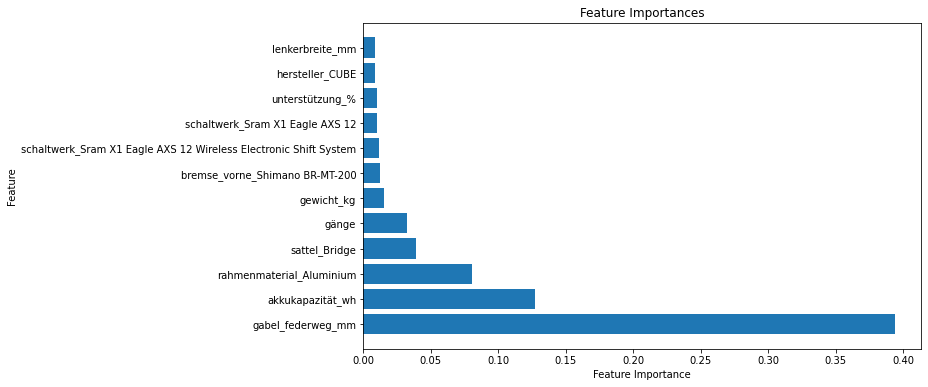

In [ ]:
import matplotlib.pyplot as plt

# Assuming your pipeline has a RandomForestRegressor as the final step
rf_regressor = pipeline_model_rf.named_steps['prediction']

# Get feature importances from the trained RandomForestRegressor
feature_importances = rf_regressor.feature_importances_

# Create a DataFrame to associate feature names with their importances
feature_importance_df = pd.DataFrame({
    'Feature': transformed_df_Xtrain.columns,
    'Importance': feature_importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df[0:12]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df[0:12]['Feature'], feature_importance_df[0:12]['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show();

In [ ]:
feature_importance_df[0:12]

,Feature,Importance
12,gabel_federweg_mm,0.393846
9,akkukapazität_wh,0.127098
5949,rahmenmaterial_Aluminium,0.080241
5616,sattel_Bridge,0.038872
1,gänge,0.032035
13,gewicht_kg,0.015020
6107,bremse_vorne_Shimano BR-MT-200,0.012594
2416,schaltwerk_Sram X1 Eagle AXS 12 Wireless Elect...,0.011540
2415,schaltwerk_Sram X1 Eagle AXS 12,0.010353
6,unterstützung_%,0.010168


###### SHAP

In [ ]:
import matplotlib.pyplot as plt
import shap
# Assuming your pipeline has a RandomForestRegressor as the final step
rf_regressor = pipeline_model_rf.named_steps['prediction']

# Calculate SHAP values for the transformed training dataset
explainer = shap.TreeExplainer(rf_regressor)
shap_values = explainer.shap_values(transformed_df_Xtrain)

# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values[0]), axis=0)

# Create a DataFrame to associate feature names with their mean SHAP values
shap_df = pd.DataFrame({
    'Feature': transformed_df_Xtrain.columns,
    'Mean_SHAP_Value': mean_abs_shap_values
})

# Sort the features by mean SHAP values in descending order
shap_df = shap_df.sort_values(by='Mean_SHAP_Value', ascending=False)

# Plot the mean SHAP values for the top features
plt.figure(figsize=(10, 6))
plt.barh(shap_df[0:12]['Feature'], shap_df[0:12]['Mean_SHAP_Value'])
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.title('Feature Importances (SHAP)')
plt.show();

java.net.NoRouteToHostException: No route to host
	at java.base/sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
	at java.base/sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:777)
	at shaded.v9_4.org.eclipse.jetty.io.SelectorManager.doFinishConnect(SelectorManager.java:355)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:232)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.access$1400(ManagedSelector.java:62)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.processSelected(ManagedSelector.java:543)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.produce(ManagedSelector.java:401)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.produceTask(EatWhatYouKill.java:360)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:184)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:171)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:129)
	at shaded.v9_4.org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:388)
	at com.databricks.rpc.ShadedInstrumentedQueuedThreadPool$$anon$2.$anonfun$run$6(InstrumentedQueuedThreadPool.scala:136)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.instrumentation.QueuedThreadPoolInstrumenter.trackActiveThreads(QueuedThreadPoolInstrumenter.scala:66)
	at com.databricks.instrumentation.QueuedThreadPoolInstrumenter.trackActiveThreads$(QueuedThreadPoolInstrumenter.scala:63)
	at com.databricks.rpc.ShadedInstrumentedQueuedThreadPool.trackActiveThreads(InstrumentedQueuedThreadPool.scala:102)
	at com.databricks.rpc.ShadedInstrumentedQueuedThreadPool$$anon$2.run(InstrumentedQueuedThreadPool.scala:131)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:806)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool$Runner.run(QueuedThreadPool.java:938)
	at java.base/java.lang.Thread.run(Thread.java:829)

###### Hyperparameter tuning with OPTUNA

In [ ]:
# RandomForest Regressor | Hyperparameter Tuning | Optuna
import sklearn

def objective(trial):
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    n_estimators = trial.suggest_int('n_estimators', 5, 150, 5) 
    max_depth = trial.suggest_int('max_depth', 1, 15, 2) 
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10, 1)         
    
    numeric_transformer = Pipeline([('Scaler', StandardScaler()), 
                                    ('R_Scaler', RobustScaler()),
                                    ('Pw_Scaler', PowerTransformer())])
    
    categorical_transformer = Pipeline([('OHE', OneHotEncoder(handle_unknown="ignore"))])
    
    transformer = ColumnTransformer([('numeric', numeric_transformer, numerics.columns),
                                     ('categoric', categorical_transformer, categorics.columns)])
    
    pipeline_model = Pipeline([('transform', transformer),
                               ('prediction', RandomForestRegressor(max_features=max_features,
                                max_leaf_nodes=max_leaf_nodes,
                                bootstrap=bootstrap,
                                n_estimators=n_estimators, 
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                random_state=42))])
  
    pipeline_model.fit(X_train, y_train)
    y_pred = pipeline_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective, n_trials=5)

study = study_rf
print()
print(f'R2: {study.best_value}')
print(f'Best parameter: {study.best_params}')

In [ ]:
RF_best_parameters = []
study = study_rf
print("R2      :", round(study.best_value, 3), "Best Parameters:", study.best_params)
RF_best_parameters.append(study.best_params)

In [ ]:
study = study_rf

numeric_transformer = Pipeline([('Scaler', StandardScaler()), 
                                ('R_Scaler', RobustScaler()),
                                ('Pw_Scaler', PowerTransformer())])

categorical_transformer = Pipeline([('OHE', OneHotEncoder(handle_unknown="ignore"))])

transformer = ColumnTransformer([('numeric', numeric_transformer, numerics.columns),
                                    ('categoric', categorical_transformer, categorics.columns)])

tuned_model = Pipeline([('transform', transformer),
                        ('prediction', RandomForestRegressor(bootstrap=study.best_params['bootstrap'],
                        max_depth=study.best_params['max_depth'],
                        max_features=study.best_params['max_features'],
                        max_leaf_nodes=study.best_params['max_leaf_nodes'],
                        n_estimators=study.best_params['n_estimators'],
                        min_samples_split=study.best_params['min_samples_split'],
                        n_jobs=-1,
                        random_state=42))])

tuned_model.fit(X_train, y_train)
y_pred = tuned_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

In [ ]:
pip install pickle

In [ ]:
import pickle
pickle.dump(pipeline_model_rf, open('final_model_rf', 'wb'))

In [ ]:
X_test.head()

,gabel_federweg_mm,akkukapazität_wh,rahmenmaterial,sattel,gänge,bremse_vorne,schaltwerk,kategorie,hersteller
4447,120,500,Aluminium,Selle Royal MTB,10,Shimano BR-M315,Shimano XT RD-M786-DSGSL Shadow Plus Direct Mo...,MTB_Fully,CUBE
23437,50,500,Aluminium,Selle Royal Nuvola,8,Shimano M315,Shimano,City,Kalkhoff
10588,140,504,Carbon,Ergon SM E-Mountain,12,Shimano XT BR-M8120 4-Piston,Sram X1 Eagle 12,MTB_Fully,GHOST
14554,63,625,Aluminium,Selle Bassano Suprema,10,Shimano BR-MT-400,Shimano Deore XT 10,Trekking,Hercules
6202,100,625,Aluminium,Natural Fit Sequence Comfort,12,Shimano BR-MT-420,Shimano Deore RD-M610 SGS Shadow Plus 12,Trekking,CUBE


In [ ]:
X_test.iloc[[2]]

,gabel_federweg_mm,akkukapazität_wh,rahmenmaterial,sattel,gänge,bremse_vorne,schaltwerk,kategorie,hersteller
10588,140,504,Carbon,Ergon SM E-Mountain,12,Shimano XT BR-M8120 4-Piston,Sram X1 Eagle 12,MTB_Fully,GHOST


In [ ]:
y_test.iloc[[2]]

Out[25]: 10588    5599
Name: uvp_€, dtype: int32

In [ ]:
rf_deploy = pickle.load(open('final_model_rf', 'rb'))
y_pred = rf_deploy.predict(X_test.iloc[[2]])
y_pred

Out[26]: array([5613.])

In [ ]:
y_test.iloc[:10]

Out[29]: 4447     2999
23437    2799
10588    5599
14554    3799
6202     2923
29372    2599
25276    2799
27313    2999
25933    2799
3122     2046
Name: uvp_€, dtype: int32

In [ ]:
control = X_test.iloc[:10].copy()
y_pred_all = []
for i in range(0, 10):
    rf_deploy = pickle.load(open('final_model_rf', 'rb'))
    y_pred = rf_deploy.predict(X_test.iloc[[i]])
    y_pred_all.append(int(y_pred[0]))
control['predicted_preis'] = y_pred_all
# control.insert(1, 'predicted_damage_type', control.pop('predicted_damage_type') )
control_rf = control.copy();
control_rf["uvp_€"] = y_test.iloc[:10]
control_rf 

,gabel_federweg_mm,akkukapazität_wh,rahmenmaterial,sattel,gänge,bremse_vorne,schaltwerk,kategorie,hersteller,predicted_preis,uvp_€
4447,120,500,Aluminium,Selle Royal MTB,10,Shimano BR-M315,Shimano XT RD-M786-DSGSL Shadow Plus Direct Mo...,MTB_Fully,CUBE,2999,2999
23437,50,500,Aluminium,Selle Royal Nuvola,8,Shimano M315,Shimano,City,Kalkhoff,2831,2799
10588,140,504,Carbon,Ergon SM E-Mountain,12,Shimano XT BR-M8120 4-Piston,Sram X1 Eagle 12,MTB_Fully,GHOST,5613,5599
14554,63,625,Aluminium,Selle Bassano Suprema,10,Shimano BR-MT-400,Shimano Deore XT 10,Trekking,Hercules,3799,3799
6202,100,625,Aluminium,Natural Fit Sequence Comfort,12,Shimano BR-MT-420,Shimano Deore RD-M610 SGS Shadow Plus 12,Trekking,CUBE,3181,2923
29372,63,500,Aluminium,Selle Royal Viento,9,TEKTRO T285,Shimano Deore M591 9,Trekking,Winora,2599,2599
25276,63,612,Aluminium,Concept SL Trekking,10,Shimano M396,Shimano XT,Trekking,Kalkhoff,2799,2799
27313,63,625,Aluminium,Selle Royal Essenza w/ Superfabric,10,Shimano BR-M200 Disc,Shimano Deore 10,Trekking,SCOTT,3099,2999
25933,50,621,Aluminium,Selle Bassano Feel GT,8,MAGURA HS-11,Shimano,City,Kalkhoff,2895,2799
3122,100,400,Aluminium,Natural Fit Sequence,9,Shimano BR-MT-200,Shimano RD-M310 SGS 9,MTB_Hardtail,CUBE,1985,2046


##### Save 'XGB' model

Shape:(31757, 52)
****************************************************************************************************
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31757 entries, 0 to 31756
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Hersteller                    31757 non-null  object 
 1   Modellname                    31757 non-null  object 
 2   Modelljahr                    31757 non-null  int32  
 3   Geschlecht                    31757 non-null  object 
 4   Kategorie                     31757 non-null  object 
 5   UVP-€                         31757 non-null  int32  
 6   Gänge                         31757 non-null  int32  
 7   Art_der_Schaltung             31757 non-null  object 
 8   Schaltwerk                    31757 non-null  object 
 9   Bremsentyp                    31757 non-null  object 
 10  Motorart                      31757 non-null  object

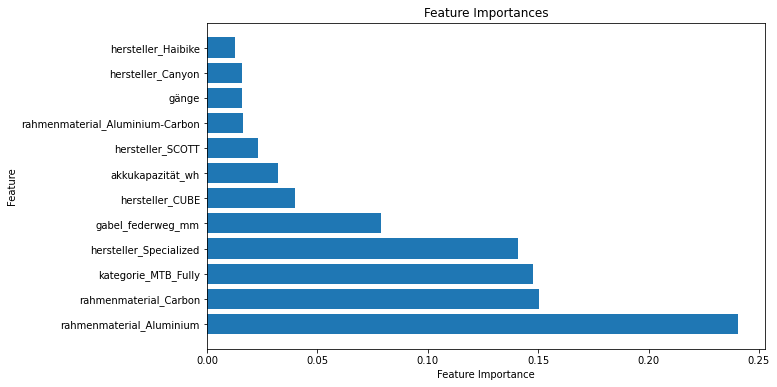

In [ ]:
file_location = "/FileStore/tables/rad/df_eBike_UVP.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
          .option("inferSchema", infer_schema) \
          .option("header", first_row_is_header) \
          .option("sep", delimiter) \
          .load(file_location).toPandas()

first_looking(df)
duplicate_values(df)

df.drop(columns=["dämpfer", "kassette"], inplace=True)

target = "uvp_€"

X =  df[['gabel_federweg_mm',
        'akkukapazität_wh',
        'rahmenmaterial',
        'gänge',
        'kategorie',
        'hersteller']]  # .drop(target, axis=1)


y = df[target]

X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     random_state=42, 
                                                     shuffle=True)

shape_control(df, X_train, y_train, X_test, y_test)

numerics = X.select_dtypes(include="number").astype("float64")
categorics = X.select_dtypes(include=["object", "category", "bool"])

numeric_transformer = Pipeline([('Scaler', StandardScaler()), 
                                ('R_Scaler', RobustScaler()),
                                ('Pw_Scaler', PowerTransformer())])

categorical_transformer = Pipeline([('OHE', OneHotEncoder(handle_unknown="ignore"))])

transformer = ColumnTransformer([('numeric', numeric_transformer, numerics.columns),
                                 ('categoric', categorical_transformer, categorics.columns)])

pipeline_model_xgb = Pipeline([('transform', transformer), ('prediction', XGBRegressor())])    

pipeline_model_xgb.fit(X_train, y_train)

y_pred = pipeline_model_xgb.predict(X_test)

def eval_metric(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"r2 score: {r2.round(2)}")
    return r2, mae, mse, rmse

r2, mae, mse, rmse = eval_metric(y_test, y_pred)
print("****************************************************************************************************")
# print(f"Inputs: {df[['gabel_federweg_mm', 'lenkerbreite_mm', 'akkukapazität_wh', 'unterstützung_%']].columns.tolist()}")
print(f"Target: {target}")
print("****************************************************************************************************")
print(f"{pipeline_model_xgb[-1]} >> r2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print("****************************************************************************************************")


######################################
transformed_features_Xtrain = transformer.fit_transform(X_train)
transformed_features_Xtest = transformer.transform(X_test)

# Get the column names of the transformed features
transformed_feature_names_Xtrain = numerics.columns.tolist() + transformer.transformers_[1][1]['OHE'].get_feature_names(categorics.columns).tolist()

# Convert the sparse matrix to a dense matrix
transformed_features_dense_Xtrain = transformed_features_Xtrain.toarray()

# Create a DataFrame with the transformed features and their names
transformed_df_Xtrain = pd.DataFrame(transformed_features_dense_Xtrain, columns=transformed_feature_names_Xtrain)

# Display the transformed DataFrame
print(transformed_df_Xtrain.head(2))


# Get the column names of the transformed features
transformed_feature_names_Xtest = numerics.columns.tolist() + transformer.transformers_[1][1]['OHE'].get_feature_names(categorics.columns).tolist()

# Convert the sparse matrix to a dense matrix
transformed_features_dense_Xtest = transformed_features_Xtest.toarray()

# Create a DataFrame with the transformed features and their names
transformed_df_Xtest = pd.DataFrame(transformed_features_dense_Xtest, columns=transformed_feature_names_Xtest)

# Display the transformed DataFrame
print(transformed_df_Xtest.head(2))
######################################

import matplotlib.pyplot as plt

# Assuming your pipeline has a RandomForestRegressor as the final step
xgb_regressor = pipeline_model_xgb.named_steps['prediction']

# Get feature importances from the trained RandomForestRegressor
feature_importances = xgb_regressor.feature_importances_

# Create a DataFrame to associate feature names with their importances
feature_importance_df = pd.DataFrame({
    'Feature': transformed_df_Xtrain.columns,
    'Importance': feature_importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df[0:12]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df[0:12]['Feature'], feature_importance_df[0:12]['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show();

In [ ]:
list(feature_importance_df['Feature'][0:12])

Out[38]: ['kategorie_MTB_Fully',
 'bremse_vorne_MAGURA MT-8',
 'rahmenmaterial_Aluminium',
 'rahmenmaterial_Carbon',
 'sattel_Bridge',
 'bremse_vorne_Shimano BR-MT-200',
 'gabel_federweg_mm',
 'bremse_vorne_Shimano BR-MT-420',
 'schaltwerk_Sram X1 Eagle AXS 12 Wireless Electronic Shift System',
 'hersteller_Specialized',
 'bremse_vorne_MAGURA HS-11',
 'motorhersteller_YAMAHA']

###### Hyperparameter tuning with OPTUNA

In [ ]:
def objective(trial):
    params = {"n_estimators": trial.suggest_int("n_estimators",10, 1000, 10),
              "max_depth": trial.suggest_int("max_depth", 2, 16),
              "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
              "subsample": trial.suggest_float("subsample", 0.2, 1),
              "num_leaves": trial.suggest_int("num_leaves", 10, 200, 10),
              "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, 100),
              "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
              "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
              "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
              "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
              "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
              "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1)
             }

    numeric_transformer = Pipeline([('Scaler', StandardScaler()), 
                                    ('R_Scaler', RobustScaler()),
                                    ('Pw_Scaler', PowerTransformer())])
    
    categorical_transformer = Pipeline([('OHE', OneHotEncoder(handle_unknown="ignore"))])
    
    transformer = ColumnTransformer([('numeric', numeric_transformer, numerics.columns),
                                     ('categoric', categorical_transformer, categorics.columns)])
    
    pipeline_model = Pipeline([('transform', transformer),
                               ('prediction', XGBRegressor(**params, random_state=42))])
  
    pipeline_model.fit(X_train, y_train)
    y_pred = pipeline_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective, n_trials=200)

study = study_xgb
print()
print(f'R2: {study.best_value}')
print(f'Best parameter: {study.best_params}')

[I 2023-08-25 18:58:54,849] A new study created in memory with name: no-name-7131e2fd-c23c-4802-96dd-48b4f008e3fa
/local_disk0/.ephemeral_nfs/envs/pythonEnv-fe59e063-8055-439a-b98f-efa6cbb47554/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].

[18:58:55] WARNING: ../src/learner.cc:627: 
Parameters: { "bagging_fraction", "bagging_freq", "feature_fraction", "lambda_l1", "lambda_l2", "min_data_in_leaf", "min_gain_to_split", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[I 2023-08-25 18:59:17,376] Trial 0 finished with value: 0.8746660186762115 and parameters: {'n_estimators': 590, 

In [ ]:
XBG_best_parameters = []
study = study_xgb
print("R2      :", round(study.best_value, 3), "Best Parameters:", study.best_params)
RF_best_parameters.append(study.best_params)

R2      : 0.876 Best Parameters: {'n_estimators': 420, 'max_depth': 11, 'learning_rate': 0.15508360455398806, 'subsample': 0.4049111039751835, 'num_leaves': 70, 'min_data_in_leaf': 6400, 'lambda_l1': 70, 'lambda_l2': 5, 'min_gain_to_split': 11.942522874480833, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}


In [ ]:
study.best_params

Out[44]: {'n_estimators': 990,
 'max_depth': 13,
 'learning_rate': 0.13102204493153047,
 'subsample': 0.7692741143797301,
 'num_leaves': 100,
 'min_data_in_leaf': 200,
 'lambda_l1': 55,
 'lambda_l2': 60,
 'min_gain_to_split': 6.26208122296979,
 'bagging_fraction': 0.2,
 'bagging_freq': 1,
 'feature_fraction': 0.5}

In [ ]:
study = study_xgb

tuned_model_xgb = Pipeline([('transform', transformer),
                        ('prediction', XGBRegressor(**study.best_params))])

tuned_model_xgb.fit(X_train, y_train)
y_pred = tuned_model_xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

[18:58:40] WARNING: ../src/learner.cc:627: 
Parameters: { "bagging_fraction", "bagging_freq", "feature_fraction", "lambda_l1", "lambda_l2", "min_data_in_leaf", "min_gain_to_split", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
import pickle
pickle.dump(tuned_model_xgb, open('final_model_xgb', 'wb'))

In [ ]:
X_test.iloc[[2]]

,kategorie,bremse_vorne,rahmenmaterial,sattel,gabel_federweg_mm,schaltwerk,hersteller
10588,MTB_Fully,Shimano XT BR-M8120 4-Piston,Carbon,Ergon SM E-Mountain,140,Sram X1 Eagle 12,GHOST


In [ ]:
y_test.iloc[[2]]

Out[50]: 10588    5599
Name: uvp_€, dtype: int32

In [ ]:
rf_deploy = pickle.load(open('final_model_xgb', 'rb'))
y_pred = rf_deploy.predict(X_test.iloc[[2]])
y_pred

Out[51]: array([5631.0215], dtype=float32)

In [ ]:
control = X_test.iloc[:10].copy()
y_pred_all = []
for i in range(0, 10):
    xgb_deploy = pickle.load(open('final_model_xgb', 'rb'))
    y_pred = rf_deploy.predict(X_test.iloc[[i]])
    y_pred_all.append(int(y_pred[0]))
control['predicted_preis'] = y_pred_all
# control.insert(1, 'predicted_damage_type', control.pop('predicted_damage_type') )
control_xgb = control.copy();
control_xgb["uvp_€"] = y_test.iloc[:10]
control_xgb 

,kategorie,bremse_vorne,rahmenmaterial,sattel,gabel_federweg_mm,schaltwerk,hersteller,predicted_preis,uvp_€
4447,MTB_Fully,Shimano BR-M315,Aluminium,Selle Royal MTB,120,Shimano XT RD-M786-DSGSL Shadow Plus Direct Mo...,CUBE,2915,2999
23437,City,Shimano M315,Aluminium,Selle Royal Nuvola,50,Shimano,Kalkhoff,2819,2799
10588,MTB_Fully,Shimano XT BR-M8120 4-Piston,Carbon,Ergon SM E-Mountain,140,Sram X1 Eagle 12,GHOST,5631,5599
14554,Trekking,Shimano BR-MT-400,Aluminium,Selle Bassano Suprema,63,Shimano Deore XT 10,Hercules,3765,3799
6202,Trekking,Shimano BR-MT-420,Aluminium,Natural Fit Sequence Comfort,100,Shimano Deore RD-M610 SGS Shadow Plus 12,CUBE,3426,2923
29372,Trekking,TEKTRO T285,Aluminium,Selle Royal Viento,63,Shimano Deore M591 9,Winora,2601,2599
25276,Trekking,Shimano M396,Aluminium,Concept SL Trekking,63,Shimano XT,Kalkhoff,2769,2799
27313,Trekking,Shimano BR-M200 Disc,Aluminium,Selle Royal Essenza w/ Superfabric,63,Shimano Deore 10,SCOTT,3108,2999
25933,City,MAGURA HS-11,Aluminium,Selle Bassano Feel GT,50,Shimano,Kalkhoff,2658,2799
3122,MTB_Hardtail,Shimano BR-MT-200,Aluminium,Natural Fit Sequence,100,Shimano RD-M310 SGS 9,CUBE,2315,2046


### Assignment-8 
24.08.2023'e kadar

    1- Bastan Asagi tam tekmil kendi E-bike prediction notebookunuzu olusturun
    2- Featuer Importance ile Secilmis featurelarin OPTUNA ile Hyperparametre Optimizationu yaparak final tuned modelinizi kaydedin
    3- 5 sayfalik bir power point presentasyonu hazirlayin

In [ ]:
# List files in a directory
dbutils.fs.ls("dbfs:/databricks/mlflow-tracking/2458957009979270/3be9f318fa8f4303a42a074a3ba90f6c/artifacts/model/model.pkl")

# # Copy a file from DBFS to local
# dbutils.fs.cp("dbfs:/your-folder-path/your-model.pkl", "file:/local-path/your-model.pkl")


---------------------------------------------------------------------------
ExecutionError                            Traceback (most recent call last)
<command-3250029155928756> in <cell line: 2>()
      1 # List files in a directory
----> 2 dbutils.fs.ls("dbfs:/databricks/mlflow-tracking/2458957009979270/3be9f318fa8f4303a42a074a3ba90f6c/artifacts/model/model.pkl")
      3 
      4 # # Copy a file from DBFS to local
      5 # dbutils.fs.cp("dbfs:/your-folder-path/your-model.pkl", "file:/local-path/your-model.pkl")

/databricks/python_shell/dbruntime/dbutils.py in f_with_exception_handling(*args, **kwargs)
    360                     exc.__context__ = None
    361                     exc.__cause__ = None
--> 362                     raise exc
    363 
    364             return f_with_exception_handling

ExecutionError: An error occurred while calling o485.ls.
: java.rmi.RemoteException: java.lang.UnsupportedOperationException: No operations allowed on this path; nested exception is: 
	

In [ ]:
# List files in a directory
dbutils.fs.ls('/databricks/driver')

files = dbutils.fs.ls("dbfs:/")
model_files = [file for file in files if file.name.endswith(".pkl")]




In [ ]:
model_files

Out[10]: []